# Exercise: EDA

This exercise is a continuation of the exploratory data analysis of the Citibike Trip Histories dataset. The first section shows code to prepare the data, followed by a section of the initial analysis. Your task is complete the EDA of the Citibike dataset. The instructions are stated in the last section of this notebook.

**IMPORTANT:** Copy this notebook and make changes in that copy. Do not push changes to this notebook.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

In [2]:
data = pd.read_csv('202102-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,304,2021-02-01 00:04:23.0780,2021-02-01 00:09:27.7920,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2
1,370,2021-02-01 00:07:08.8080,2021-02-01 00:13:19.4670,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1
2,635,2021-02-01 00:07:55.9390,2021-02-01 00:18:31.0390,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2
3,758,2021-02-01 00:08:42.0960,2021-02-01 00:21:20.7820,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0
4,522,2021-02-01 00:09:32.6820,2021-02-01 00:18:15.4100,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1


## Feature Extraction

In [3]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data['dayofweek'] = data['starttime'].dt.dayofweek
data['hourofday'] = data['starttime'].dt.hour
data['year'] = data['starttime'].dt.year

## Feature Transformation

In [4]:
data['duration_min'] = data['tripduration']/60

## Feature Generation

In [5]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33


#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [6]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [7]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

# Exploratory Data Analysis

We will do the following:
1. Examine the size and structure of the data
2. Examine each field individually
3. Examine relationships/correlations
4. Identify anomalies/outliers

## 1. Size and structure of the data

In [8]:
data.shape

(634631, 21)

After feater transformations, the dataset now has 634,631 observations with 21 variables.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634631 entries, 0 to 634630
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tripduration             634631 non-null  int64         
 1   starttime                634631 non-null  datetime64[ns]
 2   stoptime                 634631 non-null  datetime64[ns]
 3   start station id         634631 non-null  int64         
 4   start station name       634631 non-null  object        
 5   start station latitude   634631 non-null  float64       
 6   start station longitude  634631 non-null  float64       
 7   end station id           634631 non-null  int64         
 8   end station name         634631 non-null  object        
 9   end station latitude     634631 non-null  float64       
 10  end station longitude    634631 non-null  float64       
 11  bikeid                   634631 non-null  int64         
 12  usertype        

The dataset has a variety of datatypes: integer and float values, date and time, and strings. There are no variables with null/missing values.

In [10]:
# Get descriptive statistics of quantitative variables
data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
count,6.346310e+05,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.0,634631.000000,634631.000000,634631.000000
mean,1.044040e+03,2113.291434,40.741955,-73.976605,2113.355662,40.741686,-73.976779,41295.079259,1971.745553,0.342484,3.147275,14.011964,2021.0,17.400660,49.254447,1.840111
std,1.206238e+04,1576.082952,0.034753,0.022764,1576.501895,0.034642,0.022868,7149.176733,8.307802,0.608901,1.865895,4.586800,0.0,201.039591,8.307802,1.562775
min,6.100000e+01,72.000000,40.644512,-74.023087,72.000000,40.644512,-74.043991,14534.000000,1885.000000,0.000000,0.000000,0.000000,2021.0,1.016667,17.000000,0.000000
25%,3.450000e+02,438.000000,40.718822,-73.992573,437.000000,40.718822,-73.993012,36480.000000,1969.000000,0.000000,2.000000,11.000000,2021.0,5.750000,52.000000,0.786475
50%,5.930000e+02,3115.000000,40.741740,-73.981540,3115.000000,40.741459,-73.981687,42766.000000,1969.000000,0.000000,3.000000,15.000000,2021.0,9.883333,52.000000,1.396765
75%,1.036000e+03,3538.000000,40.764719,-73.961255,3537.000000,40.763954,-73.961199,47762.000000,1969.000000,1.000000,5.000000,17.000000,2021.0,17.266667,52.000000,2.411052
max,2.065242e+06,4419.000000,40.852252,-73.884308,4419.000000,40.852252,-73.884308,50133.000000,2004.000000,2.000000,6.000000,23.000000,2021.0,34420.700000,136.000000,17.937935


Although these variables are all quantitative, it doesn't really make sense to look at the statistics for unique IDs and spatial data like `start station id`, `start station latitude`, `start station longitude`, and `bikeid`, among others. Here, we will just focus on the values for `birth year`, `duration_min`, `age`, and `distance_km`.

Few insights from the `data.describe()` function:

1. The minimum `birth year` is 1885 which has a remarkably large difference from the 25th percentile value. Can this be anomalous data?
2. There is a very large difference between the maximum and 75th percentile values of `duration_min` and `age`.
3. Observations #1 & #2 indicate possible outliers in the data. 

In [11]:
data.describe(include=np.object)

,start station name,end station name,usertype
count,634631,634631,634631
unique,1274,1283,2
top,1 Ave & E 68 St,1 Ave & E 68 St,Customer
freq,4251,4226,468459


These are the descriptive stats for the categorical variables. 

## 2. Examining individual variables

Now, we can start generating simple visualizations to help us better understand the values in each variable.

#### User type

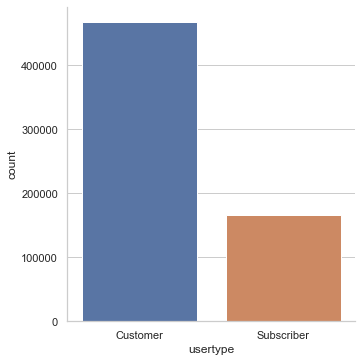

In [12]:
sns.set_theme(style="whitegrid")

usertype_plot = sns.catplot(x="usertype", kind="count", order=["Customer", "Subscriber"], data=data)

There are more one-time users of CitiBike than there are subscribers.

#### Age

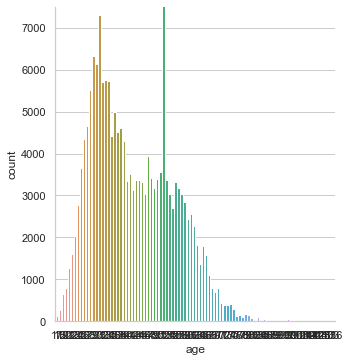

In [13]:
age_plot = sns.catplot(x="age", kind="count", data=data)
age_plot.set(ylim=(0,7500)) # Limit the maximum y-axis value because of one outlier count for age 52

In [14]:
data["age"].value_counts()

52     464712
31       7312
29       6327
30       6135
33       5758
        ...  
103         2
130         2
93          2
88          2
136         1
Name: age, Length: 92, dtype: int64

#### Starting Stations

In [15]:
start_stations = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
start_stations = start_stations.nlargest(10, 'counts')
start_stations

,Station name,counts
0,1 Ave & E 68 St,4251
1,W 21 St & 6 Ave,3762
2,E 17 St & Broadway,3230
3,W 33 St & 7 Ave,3213
4,E 13 St & Avenue A,3044
5,E 33 St & 1 Ave,2970
6,Broadway & W 60 St,2757
7,Grand St & Elizabeth St,2700
8,Clinton St & Grand St,2620
9,Pershing Square North,2606


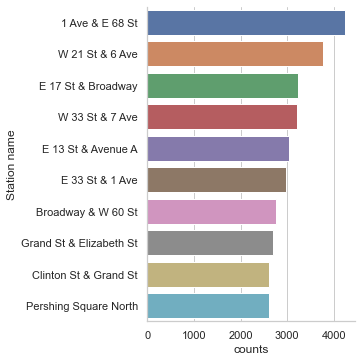

In [16]:
start_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=start_stations)

#### Ending stations

In [17]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')
end_stations

,Station name,counts
0,1 Ave & E 68 St,4226
1,W 21 St & 6 Ave,3734
2,E 17 St & Broadway,3481
3,W 33 St & 7 Ave,3161
4,E 13 St & Avenue A,3043
5,E 33 St & 1 Ave,3004
6,Broadway & W 60 St,2789
7,Grand St & Elizabeth St,2723
8,Pershing Square North,2622
9,Clinton St & Grand St,2611


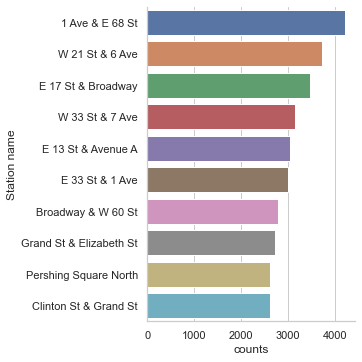

In [18]:
end_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=end_stations)

We can see from both plots that the top 10 start and end stations are consistent with each other. This indicates high taffic areas which can be potential locations for adding more bikes and bike docks. 

#### Origin-Destination Pairs

Here we create `od_trips` which contains the origin-destination pairs derived from the unique pairs of `start station name` and `end station name`.

In [19]:
## Count of rides per OD
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")
od_trips.head()

,start,end,total_trips
0,1 Ave & E 110 St,1 Ave & E 110 St,17
1,1 Ave & E 110 St,1 Ave & E 68 St,11
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2


In [20]:
od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]
od_trips

,start,end,total_trips,od
0,1 Ave & E 110 St,1 Ave & E 110 St,17,1 Ave & E 110 St to 1 Ave & E 110 St
1,1 Ave & E 110 St,1 Ave & E 68 St,11,1 Ave & E 110 St to 1 Ave & E 68 St
2,1 Ave & E 110 St,1 Ave & E 78 St,1,1 Ave & E 110 St to 1 Ave & E 78 St
3,1 Ave & E 110 St,1 Ave & E 94 St,2,1 Ave & E 110 St to 1 Ave & E 94 St
4,1 Ave & E 110 St,2 Ave & E 104 St,2,1 Ave & E 110 St to 2 Ave & E 104 St
...,...,...,...,...
164369,Wythe Ave & Metropolitan Ave,Willoughby Ave & Tompkins Ave,2,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164370,Wythe Ave & Metropolitan Ave,Willoughby Ave & Walworth St,1,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164371,Wythe Ave & Metropolitan Ave,Willoughby St & Fleet St,1,Wythe Ave & Metropolitan Ave to Willoughby St ...
164372,Wythe Ave & Metropolitan Ave,Wyckoff Av & Stanhope St,1,Wythe Ave & Metropolitan Ave to Wyckoff Av & S...


/Applications/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


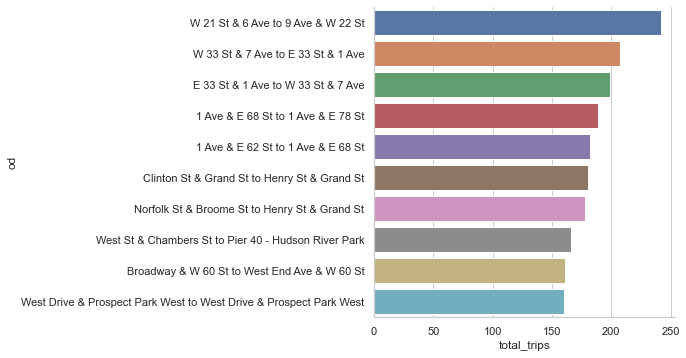

In [21]:
od_rank_plot = sns.catplot(y="od", x="total_trips", orient="h", kind="bar", data=od_trips.nlargest(10, "total_trips"))

#### Origin-Destination Matrix

In this part, we focus on analyzing the number of trips between the top 10 `start` and `end` stations. It would be impossible to visually analyze for all possible pairs because the dataset is too big.

In [22]:
# Get the trips between the top 10 stations.

od_topten = od_trips[od_trips.start.isin(start_stations["Station name"]) & od_trips.end.isin(end_stations["Station name"])]
od_topten

,start,end,total_trips,od
2318,1 Ave & E 68 St,1 Ave & E 68 St,87,1 Ave & E 68 St to 1 Ave & E 68 St
2433,1 Ave & E 68 St,Broadway & W 60 St,37,1 Ave & E 68 St to Broadway & W 60 St
2451,1 Ave & E 68 St,Clinton St & Grand St,2,1 Ave & E 68 St to Clinton St & Grand St
2482,1 Ave & E 68 St,E 13 St & Avenue A,8,1 Ave & E 68 St to E 13 St & Avenue A
2489,1 Ave & E 68 St,E 17 St & Broadway,9,1 Ave & E 68 St to E 17 St & Broadway
...,...,...,...,...
145506,W 33 St & 7 Ave,E 33 St & 1 Ave,207,W 33 St & 7 Ave to E 33 St & 1 Ave
145574,W 33 St & 7 Ave,Grand St & Elizabeth St,4,W 33 St & 7 Ave to Grand St & Elizabeth St
145621,W 33 St & 7 Ave,Pershing Square North,93,W 33 St & 7 Ave to Pershing Square North
145660,W 33 St & 7 Ave,W 21 St & 6 Ave,21,W 33 St & 7 Ave to W 21 St & 6 Ave


In [23]:
# Create a matrix

od_matrix = pd.pivot_table(od_topten, index='start', columns='end', values='total_trips', aggfunc=np.sum, fill_value=0)
od_matrix

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,87,37,2,8,9,11,13,13,1,62
Broadway & W 60 St,35,89,1,0,6,1,1,9,2,6
Clinton St & Grand St,0,1,97,20,11,1,90,3,4,0
E 13 St & Avenue A,10,0,18,107,35,5,11,3,30,5
E 17 St & Broadway,4,3,9,46,81,22,8,20,78,13
E 33 St & 1 Ave,40,1,1,23,32,64,8,84,32,199
Grand St & Elizabeth St,1,0,96,15,15,8,70,0,16,0
Pershing Square North,31,9,3,8,20,108,0,27,11,84
W 21 St & 6 Ave,2,4,6,19,25,12,8,10,69,18


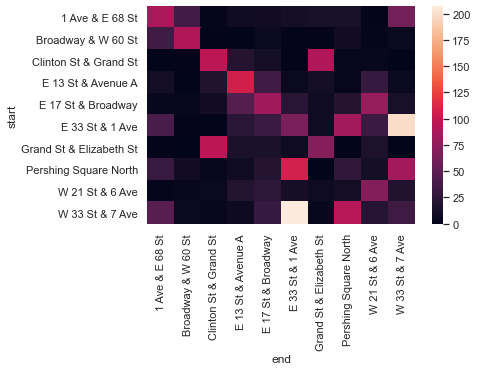

In [24]:
# Generate a heatmap

od_heatmap = sns.heatmap(od_matrix)

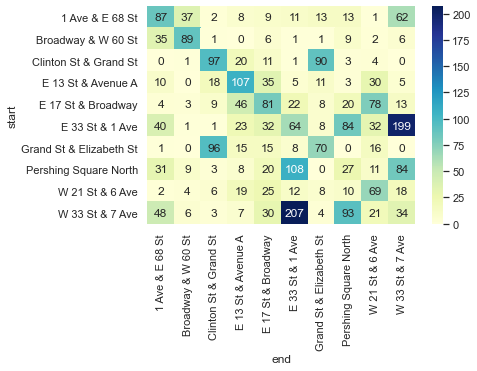

In [25]:
# Change color palette

od_heatmap = sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt="d")

#### Gender

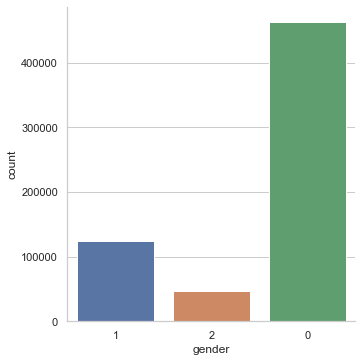

In [26]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2, 0], data=data)

It seems that the dataset contains mostly zero (0) values for the gender. We can continue our analysis by removing those trips with unknown gender.

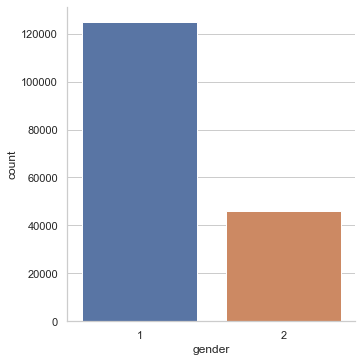

In [27]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2], data=data[data["gender"] > 0])

#### Day of week

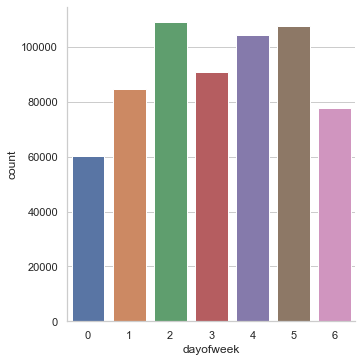

In [28]:
dow_plot = sns.catplot(x="dayofweek", kind="count", data=data)

The values for `dayofweek` starts with `0` or `Monday` and ends with `6` or `Sunday`. Based on the bar plot above, most trips happen on Wednesdays, Fridays and Saturdays.

#### Hour of day

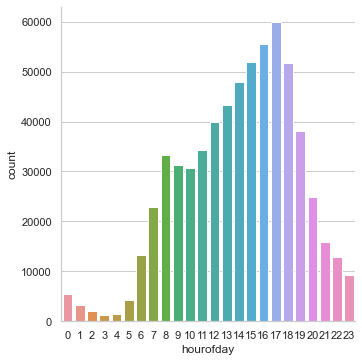

In [29]:
hod_plot = sns.catplot(x="hourofday", kind="count", data=data)

From the plot, the number of trips starts increasing from 12 noon and peaks at 5PM. 

#### Duration in minutes

In [30]:
data["duration_min"].describe()

count    634631.000000
mean         17.400660
std         201.039591
min           1.016667
25%           5.750000
50%           9.883333
75%          17.266667
max       34420.700000
Name: duration_min, dtype: float64

#### Detect and remove outliers

Outliers are defined as values that is more than 3 standard deviations away from the mean. Here, we detect them by computing the z score of each value, which is relative to the mean and standard deviation.

In [31]:
z_scores = zscore(data["duration_min"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_entries = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
duration_min_outliers = (abs_z_scores >= 3)
data[duration_min_outliers].duration_min # Show outlier values

55        3793.983333
128       4257.516667
280       1364.983333
287       3014.366667
290       3205.933333
             ...     
631214    7005.816667
632255    1363.300000
633024    5281.700000
633398    6875.366667
633877    1165.300000
Name: duration_min, Length: 624, dtype: float64

#### Histograms with KDE

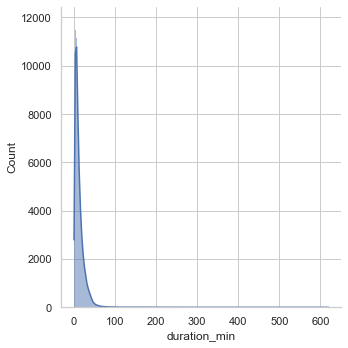

In [32]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)

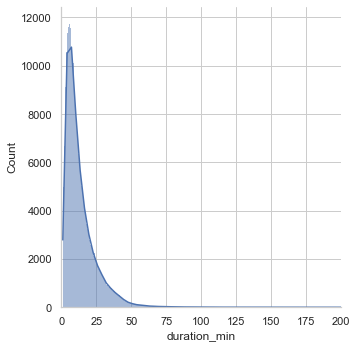

In [33]:
# Zoom in a little closer. Let's limit the x-axis to only show values up to 200

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 200))

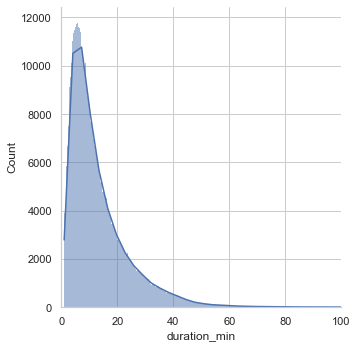

In [34]:
# Zoom in more. Let's limit the x-axis to only show values up to 100

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 100))

#### ECDF with Rug Plots

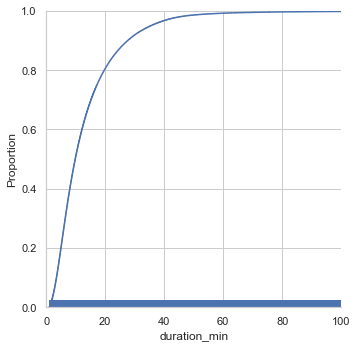

In [35]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kind="ecdf", rug=True)
duration_plot.set(xlim=(0, 100))

## 3. Examine relationships/correlations

### User type and gender

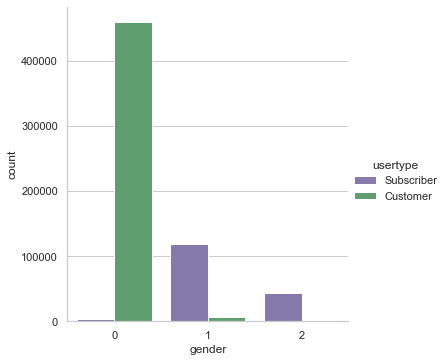

In [36]:
usertype_gender_plot = sns.catplot(x="gender", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

- Users with 24-hour pass or 3-day passes did not have their gender information recorded.
- More male subscribers than females. 

### Trip distance, duration and user type

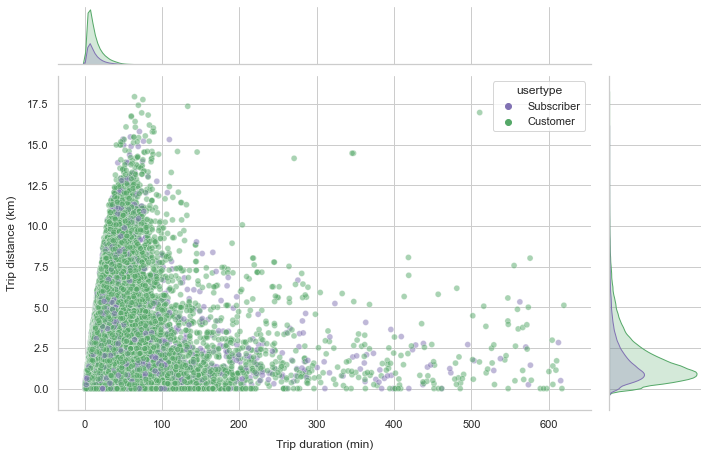

In [37]:
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

In [38]:
z_scores = zscore(data["distance_km"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_dist = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_z_scores >= 3)
data[dist_outliers].distance_km # Show outlier values

72        7.559672
79        6.791290
107       7.055636
123       7.133794
287       6.816675
            ...   
634021    8.016243
634081    7.339160
634088    8.447268
634167    7.635918
634521    6.830051
Name: distance_km, Length: 11992, dtype: float64

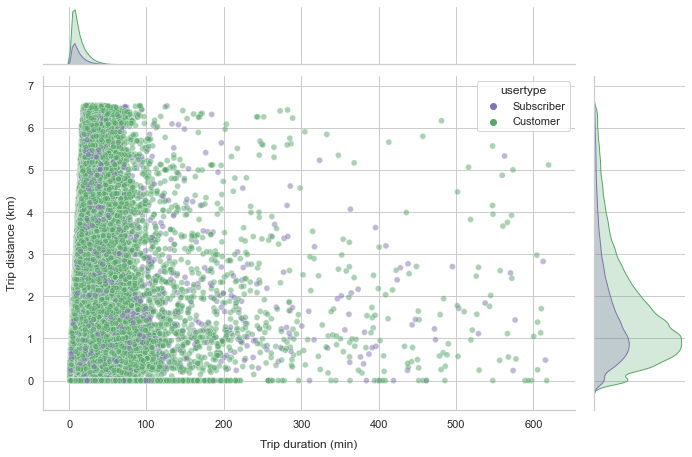

In [39]:
# Plot with outliers for both duration and distance
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

### Get correlation between quantitative variables

In [40]:
data_to_corr = data[["gender", "duration_min", "age", "distance_km"]]
data_to_corr

,gender,duration_min,age,distance_km
0,2,5.066667,25,0.828754
1,1,6.166667,30,0.487242
2,2,10.583333,41,0.971186
3,0,12.633333,52,2.124707
4,1,8.700000,33,1.342431
...,...,...,...,...
634626,1,2.250000,33,0.233175
634627,0,5.966667,52,0.555965
634628,0,4.816667,52,0.925453
634629,1,2.766667,35,0.632157


In [41]:
# Get z scores of the following variables
z_scores = zscore(data_to_corr[["duration_min", "age", "distance_km"]]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_rows = (abs_z_scores < 3).all(axis=1) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
data_to_corr_outliers = (abs_z_scores >= 3)
data_to_corr[data_to_corr_outliers] # Show outlier values

,gender,duration_min,age,distance_km
25,1,19.883333,21,0.000000
28,1,18.783333,23,1.313043
32,1,4.600000,23,0.835615
33,1,21.833333,22,1.009758
37,1,6.316667,21,0.872510
...,...,...,...,...
634413,1,3.650000,79,0.435061
634474,0,43.750000,21,0.814466
634478,1,23.783333,23,4.652121
634521,0,41.866667,52,6.830051


In [42]:
# Remove outliers
data_to_corr = data_to_corr[filtered_rows]

#### Correlation Heatmap

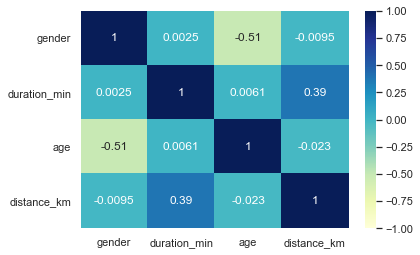

In [43]:
data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                vmin=-1, 
                                vmax=1)

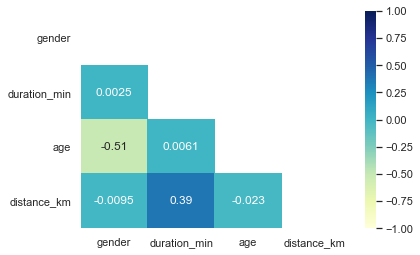

In [44]:
mask = np.triu(np.ones_like(data_to_corr.corr(), dtype=bool))

data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                mask=mask,
                                vmin=-1, 
                                vmax=1)

Variables `distance_km` and `duration_min` showed some positive correlation. We can still include them as features in a modeling task later.

----
----

# Exercise Proper: Continuation of EDA

We are already done in examining the individual characteristics of each variable in the dataset. You're task is to continue examining the remaining relationships (bivariate/multivariate) between variables. Here are some that you can prioritize:

- Bivariate: Trip duration & time of day
- Bivariate: User type & age
- Bivariate: Start station & user type
- Bivariate: End station & user type
- Bivariate: End station & gender
- Multi: Start station, end station & trip duration
- Multi: Start station, end station & unique users
- Multi: Start station, end station & user type
- Multi: Trip distance, duration & gender
- Multi: Average trip distance per unique user, average duration per unique user & user type
- Multi: Average trip distance per unique user, average duration per unique user, gender & user type

After creating simple visualizations for each, write down your observations in a separate cell. You do not have to interpret yet why those relationships appear. We're still doing EDA. Relax ;)

### Trip duration and time of day

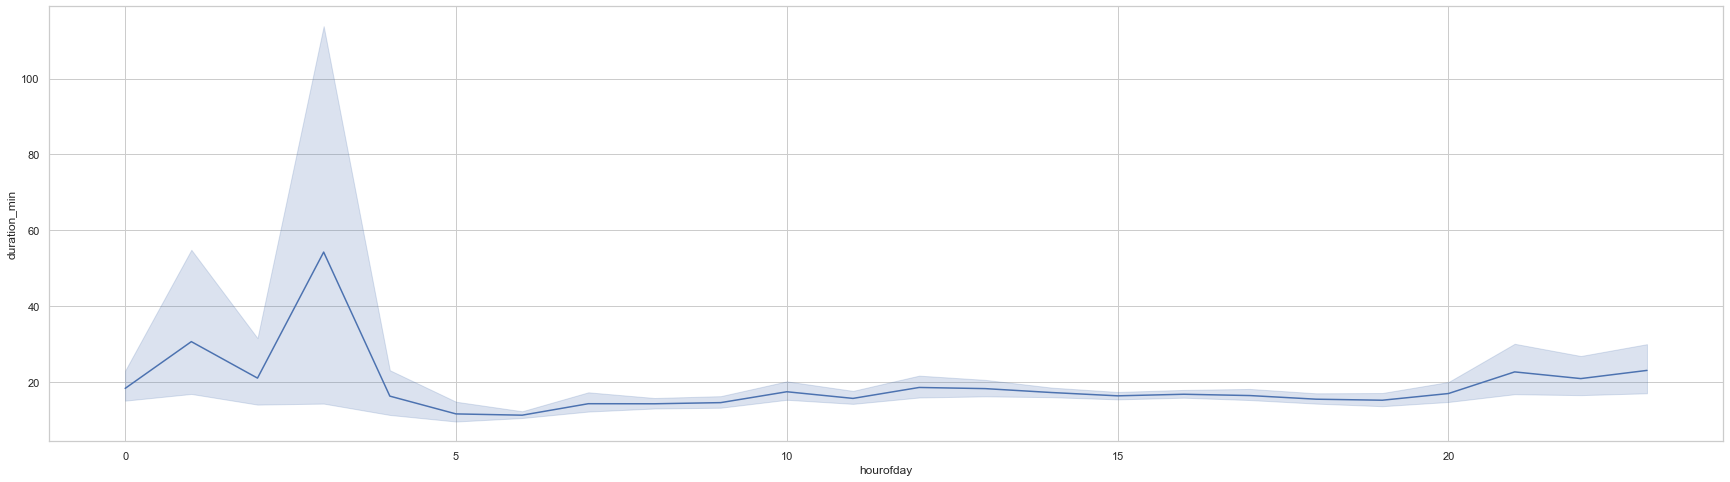

In [45]:
dur_time_plot = sns.lineplot(x="hourofday", y="duration_min", data=data[filtered_dist])
dur_time_plot.figure.set_size_inches(30, 8)

### User type and age

As can be seen, there are longer trip durations in the early hours of the day where the peak lies at the 3am mark where the mean trip duration is around 55 minutes. For the rest of the day, the trip duration remains low in the 10 - 15 minute range, with a slight increase in the later hours of the evening.

In [46]:
data['age'].value_counts()

52     464712
31       7312
29       6327
30       6135
33       5758
        ...  
103         2
130         2
93          2
88          2
136         1
Name: age, Length: 92, dtype: int64

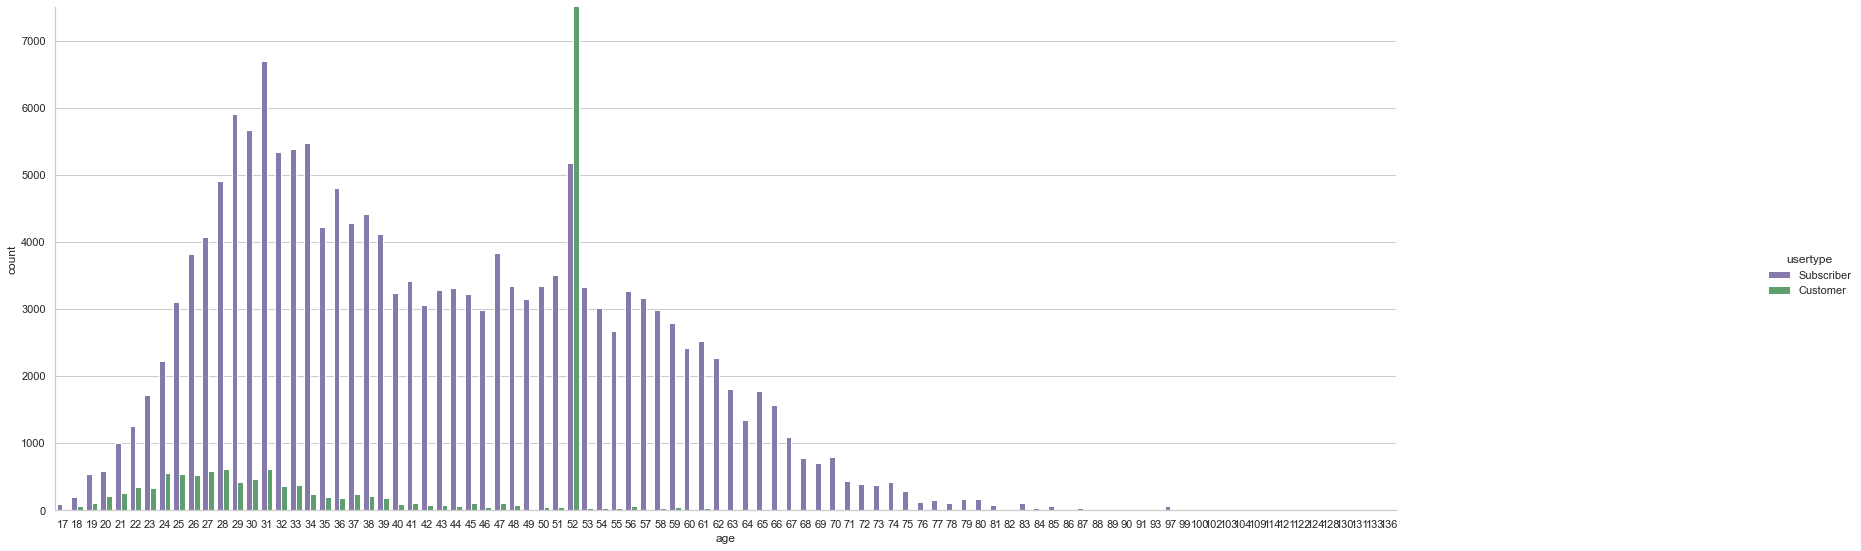

In [47]:
usertype_age_plot = sns.catplot(x="age", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

usertype_age_plot.set(ylim=(0,7500))
usertype_age_plot.fig.set_size_inches(30, 8)

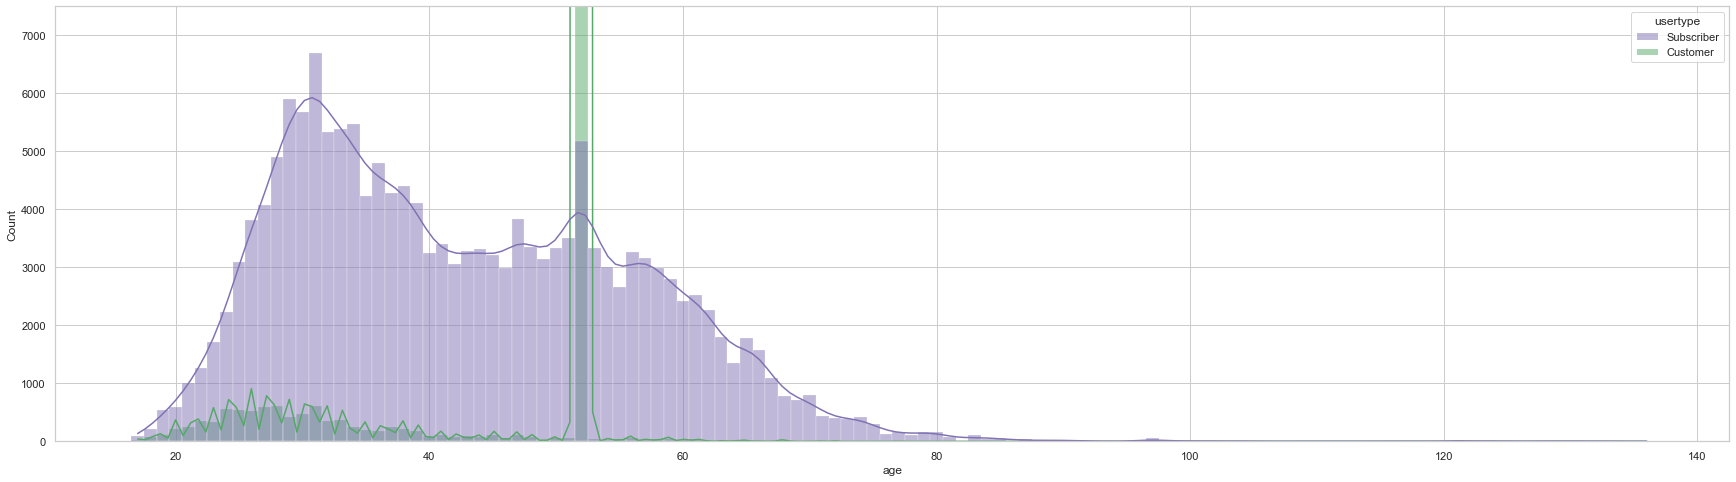

In [48]:
usertype_age_histplot = sns.histplot(data, 
                                     x="age", 
                                     hue="usertype", 
                                     palette={"Customer": "g", "Subscriber": "m"}, 
                                     element="bars", 
                                     discrete=True,
                                    kde = True)
usertype_age_histplot.set(ylim=(0,7500))
usertype_age_histplot.figure.set_size_inches(30, 8)

Evidently, among all age groups, there are more subscribers than customers with the exception of age group 52 with an enormous record of 464,712 customers (for viewing purposes, this is cut off in the graph). Additionally, the distribution shows that most subscribers are found in the late 20s to early 30s age bracket. 

### Start station and user type (Giann)

For this, we will use the start_stations and get data from the data variable based on the top 10 start stations.

In [49]:
mod_data = data[["start station name", "usertype"]]

In [50]:
labels = start_stations.copy() ##get a copy of start_stations

In [51]:
##divide by usertype and drop the usertype after
cust_mod_data = mod_data[mod_data["usertype"] == "Customer"]
sub_mod_data = mod_data[mod_data["usertype"] == "Subscriber"]

cust_mod_data = cust_mod_data.drop("usertype",axis=1)
sub_mod_data = sub_mod_data.drop("usertype",axis=1)

In [52]:
#just like with the start_stations
cust_mod_data = cust_mod_data["start station name"].value_counts().rename_axis('Station name').reset_index(name='ncustomers')
sub_mod_data = sub_mod_data["start station name"].value_counts().rename_axis('Station name').reset_index(name='nsubscribers')

In [53]:
#for every customer in cust_mod_data, if the station name the customer is at is present
#in the start_station variable (top 10 start stations), we keep it; else; we drop it
for i in range(0,len(cust_mod_data),1):
    flag = 1
    for m in range(0,len(labels),1):
        condition = cust_mod_data["Station name"][i] == labels["Station name"][m]
        if(condition == True):
            flag = 0

    if(flag == 1):
        cust_mod_data = cust_mod_data.drop([i],axis=0)
        i = i-1

In [54]:
#same process with subscriber
for i in range(0,len(sub_mod_data),1):
    flag = 1
    for m in range(0,len(labels),1):
        condition = sub_mod_data["Station name"][i] == labels["Station name"][m]
        if(condition == True):
            flag = 0

    if(flag == 1):
        sub_mod_data = sub_mod_data.drop([i],axis=0)
        i = i-1

In [55]:
x = start_stations.copy()
y = cust_mod_data.copy()
z = sub_mod_data.copy()

x= x.sort_values(by="Station name",ignore_index=True)
y= y.sort_values(by="Station name",ignore_index=True)
z= z.sort_values(by="Station name",ignore_index=True)

In [56]:
x.insert(2, "customers", y["ncustomers"], True)
x.insert(3, "subscribers", z["nsubscribers"],True)

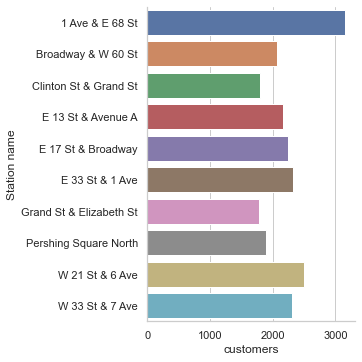

In [57]:
cust_station_plot = sns.catplot(y="Station name", x="customers", orient="h", kind="bar", data=x)

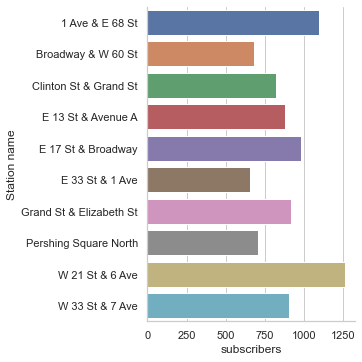

In [58]:
sub_station_plot = sns.catplot(y="Station name", x="subscribers", orient="h", kind="bar", data=x)

**Observation:** The foot traffic is much more present in 1 Ave & E 68 St., and W 21 St. & 6 Ave. for both customers and subscribers. This can provide business opportunities for the citibike business.

### End station and user type (Giann)

In [59]:
mod_data2 = data[["end station name", "usertype"]]

In [60]:
labels2 = end_stations.copy()

In [61]:
cust_mod_data2 = mod_data2[mod_data2["usertype"] == "Customer"]
sub_mod_data2 = mod_data2[mod_data2["usertype"] == "Subscriber"]

cust_mod_data2 = cust_mod_data2.drop("usertype",axis=1)
sub_mod_data2 = sub_mod_data2.drop("usertype",axis=1)

In [62]:
cust_mod_data2 = cust_mod_data2["end station name"].value_counts().rename_axis('Station name').reset_index(name='ncustomers')
sub_mod_data2 = sub_mod_data2["end station name"].value_counts().rename_axis('Station name').reset_index(name='nsubscribers')

In [63]:
for i in range(0,len(cust_mod_data),1):
    flag = 1
    for m in range(0,len(labels),1):
        condition = cust_mod_data2["Station name"][i] == labels2["Station name"][m]
        if(condition == True):
            flag = 0

    if(flag == 1):
        cust_mod_data2 = cust_mod_data2.drop([i],axis=0)
        i = i-1

In [64]:
for i in range(0,len(sub_mod_data),1):
    flag = 1
    for m in range(0,len(labels),1):
        condition = sub_mod_data2["Station name"][i] == labels2["Station name"][m]
        if(condition == True):
            flag = 0

    if(flag == 1):
        sub_mod_data2 = sub_mod_data2.drop([i],axis=0)
        i = i-1

In [65]:
x = start_stations.copy()
y = cust_mod_data2.copy()
z = sub_mod_data2.copy()

x= x.sort_values(by="Station name",ignore_index=True)
y= y.sort_values(by="Station name",ignore_index=True)
z= z.sort_values(by="Station name",ignore_index=True)

In [66]:
x.insert(2, "customers", y["ncustomers"], True)
x.insert(3, "subscribers", z["nsubscribers"],True)

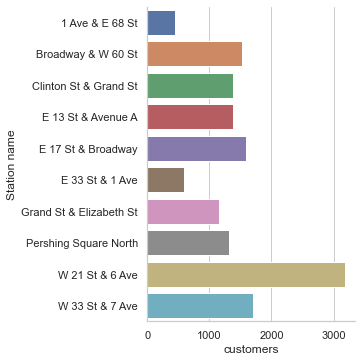

In [67]:
cust_station_plot = sns.catplot(y="Station name", x="customers", orient="h", kind="bar", data=x)

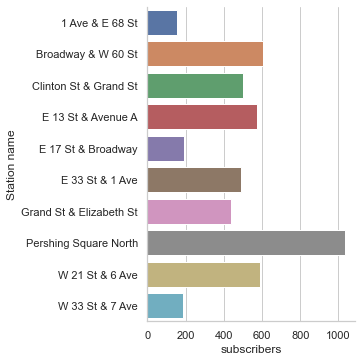

In [68]:
sub_station_plot = sns.catplot(y="Station name", x="subscribers", orient="h", kind="bar", data=x)

**Observation:** Pershing Square North and W 21 St & 6 Ave are the most frequented stations for Subscriber and Customer respectively. Also noteworthy observation is 1 Ave & E 68 St. being one of the least frequented end stations for subscribers and customers.

### End station and gender

In [69]:
topten_end_stations = data["end station name"].value_counts().rename_axis('end station name').reset_index(name='counts').nlargest(10, 'counts')
gender_end_data = topten_end_stations.merge(data)

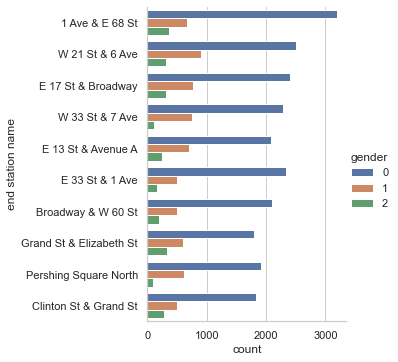

In [70]:
sns.catplot(data=gender_end_data, kind="count", x=None, y="end station name", hue="gender")

The catplot shows that it is consistent for the top ten end stations to have the large majority of its passengers to be of an unknown gender (0). Aside from that, it is also consistent that there are more passengers of gender value 1 than that of gender value 2 in all of the top ten end stations.

### Start station, end station and trip duration

In [71]:
od_duration = data[filtered_entries].groupby(['start station name', 'end station name'], as_index=False)['duration_min'].mean()
od_duration = od_duration.rename(columns={'start station name': 'start', 'end station name': 'end'})
od_duration = od_duration.merge(od_topten, on=['start', 'end'])

od_duration = pd.pivot_table(od_duration, index='start', columns='end', values='duration_min', fill_value=0)

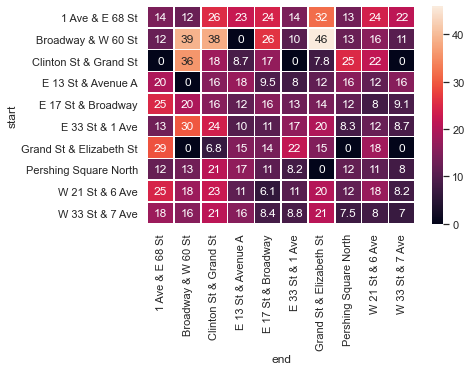

In [72]:
od_duration_heatmap = sns.heatmap(od_duration, annot=True, linewidths=.5)

Among the top ten start and end stations, it is the route from *Broadway & W 60 St* to *Grand St & Elizabeth St* that has the longest average duration time, which is 46 minutes. On the other hand, the quickest average duration time is the route from *W 21 St & 6 Ave* to *E 17 St & Broadway*, which is 6.1 minutes.

There are nine (9) routes which have a 0 value for average duration time, which could either mean that there are no available data for it or it was filtered out as an outlier.

### Start station, end station and unique users

In [73]:
odu = pd.DataFrame(columns=['start', 'end', "bikeid"], data=data[["start station name","end station name","bikeid"]].values)
odu = odu.drop_duplicates()
odu = odu.groupby(['start', 'end'], as_index=False)['bikeid'].count()
odu = odu.rename(columns={"bikeid": "unique"}, errors="raise")
odu = odu[odu.start.isin(start_stations["Station name"]) & odu.end.isin(end_stations["Station name"])]

In [74]:
odu_matrix = pd.pivot_table(odu, index='start', columns='end', values='unique', aggfunc=np.sum, fill_value=0)

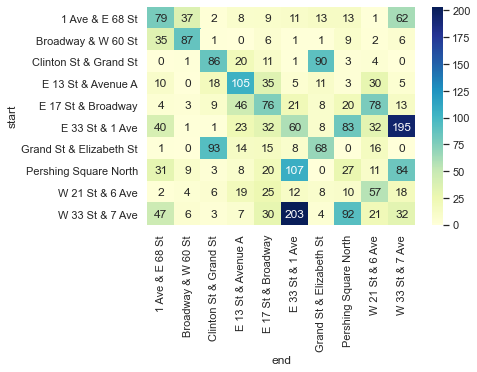

In [75]:
odu_heatmap = sns.heatmap(odu_matrix, cmap="YlGnBu", annot=True, fmt="d")

The map shows the number of users who have travelled the origin-destination pairs. It can be observed that the route that had been travelled the most by a number of users is the route `W33 St & 7 Ave` to `E 33 St. & l Ave` with a record of 203 users, and vice versa with a record of 195 users. 

### Start station, end station and user type

In [76]:
od_trips_usertype = data.groupby(['start station name', 
                                  'end station name'],
                                 as_index=False).agg(customers=("usertype", lambda x: (sum(np.fromiter((y == "Customer" for y in x), int)))),
                                                    subscribers=("usertype", lambda x: (sum(np.fromiter((y == "Subscriber" for y in x), int))))
                                                    ) 
od_trips_usertype["usertype_scale"] = (od_trips_usertype["customers"] +  (od_trips_usertype["subscribers"] * -1)) / (od_trips_usertype["customers"] + od_trips_usertype["subscribers"])
od_trips_usertype

,start station name,end station name,customers,subscribers,usertype_scale
0,1 Ave & E 110 St,1 Ave & E 110 St,12,5,0.411765
1,1 Ave & E 110 St,1 Ave & E 68 St,10,1,0.818182
2,1 Ave & E 110 St,1 Ave & E 78 St,0,1,-1.000000
3,1 Ave & E 110 St,1 Ave & E 94 St,0,2,-1.000000
4,1 Ave & E 110 St,2 Ave & E 104 St,2,0,1.000000
...,...,...,...,...,...
164369,Wythe Ave & Metropolitan Ave,Willoughby Ave & Tompkins Ave,2,0,1.000000
164370,Wythe Ave & Metropolitan Ave,Willoughby Ave & Walworth St,1,0,1.000000
164371,Wythe Ave & Metropolitan Ave,Willoughby St & Fleet St,1,0,1.000000
164372,Wythe Ave & Metropolitan Ave,Wyckoff Av & Stanhope St,0,1,-1.000000


**Note:** We represent `usertype` as a continuous variable from the range [-1, 1] such that a value of -1 indicates that a route only has subscribers, while a value of 1 indicates that a route only has customers. This would be needed in generating a heatmap.

In [77]:
od_trips_usertype = od_trips_usertype.rename(columns={"start station name": "start", "end station name": "end"}, errors="raise")
od_trips_usertype.head()

,start,end,customers,subscribers,usertype_scale
0,1 Ave & E 110 St,1 Ave & E 110 St,12,5,0.411765
1,1 Ave & E 110 St,1 Ave & E 68 St,10,1,0.818182
2,1 Ave & E 110 St,1 Ave & E 78 St,0,1,-1.000000
3,1 Ave & E 110 St,1 Ave & E 94 St,0,2,-1.000000
4,1 Ave & E 110 St,2 Ave & E 104 St,2,0,1.000000


In [78]:
od_usertype_topten = od_trips_usertype[od_trips_usertype.start.isin(start_stations["Station name"]) & od_trips_usertype.end.isin(end_stations["Station name"])]
od_usertype_topten

,start,end,customers,subscribers,usertype_scale
2318,1 Ave & E 68 St,1 Ave & E 68 St,69,18,0.586207
2433,1 Ave & E 68 St,Broadway & W 60 St,22,15,0.189189
2451,1 Ave & E 68 St,Clinton St & Grand St,1,1,0.000000
2482,1 Ave & E 68 St,E 13 St & Avenue A,7,1,0.750000
2489,1 Ave & E 68 St,E 17 St & Broadway,7,2,0.555556
...,...,...,...,...,...
145506,W 33 St & 7 Ave,E 33 St & 1 Ave,143,64,0.381643
145574,W 33 St & 7 Ave,Grand St & Elizabeth St,3,1,0.500000
145621,W 33 St & 7 Ave,Pershing Square North,70,23,0.505376
145660,W 33 St & 7 Ave,W 21 St & 6 Ave,13,8,0.238095


In [79]:
od_usertype_matrix = pd.pivot_table(od_usertype_topten, index='start', columns='end', values='usertype_scale', aggfunc=np.sum)
od_usertype_matrix

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,0.586207,0.189189,0.000000,0.750000,0.555556,0.636364,0.846154,0.384615,1.000000,0.064516
Broadway & W 60 St,0.428571,0.730337,1.000000,NaN,0.333333,1.000000,1.000000,1.000000,1.000000,0.666667
Clinton St & Grand St,NaN,1.000000,0.463918,0.000000,0.454545,1.000000,0.377778,0.333333,1.000000,NaN
E 13 St & Avenue A,0.400000,NaN,0.000000,0.420561,0.428571,0.600000,0.272727,1.000000,0.333333,0.600000
E 17 St & Broadway,0.500000,1.000000,0.111111,0.391304,0.382716,0.545455,0.250000,0.400000,0.256410,0.692308
E 33 St & 1 Ave,0.700000,1.000000,1.000000,0.739130,0.312500,0.656250,0.000000,0.309524,0.812500,0.266332
Grand St & Elizabeth St,1.000000,NaN,0.375000,0.200000,0.333333,0.500000,0.314286,NaN,0.500000,NaN
Pershing Square North,0.741935,0.555556,-0.333333,0.500000,0.600000,0.370370,NaN,0.703704,0.636364,0.500000
W 21 St & 6 Ave,1.000000,1.000000,1.000000,0.578947,0.280000,0.833333,0.250000,0.600000,0.652174,0.555556


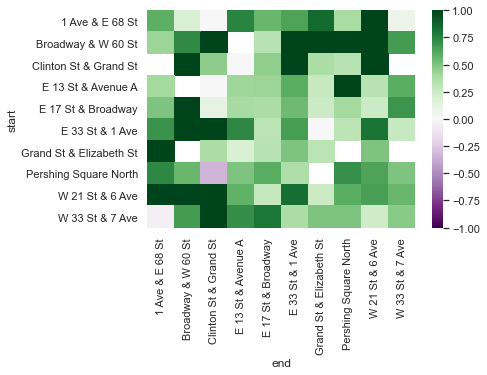

In [80]:
od_usertype_heatmap = sns.heatmap(od_usertype_matrix,
                                  cmap="PRGn",
                                  vmin=-1,
                                  vmax=1
                                 )

Notably, most of the bikers in the top 10 origin-destination pairs are customers as indicated by the almost green-filled heatmap. In some areas, there are only customer bikers which is represented as the dark green boxes. Meanwhile, only the Pershing Square North to Clinton St & Grand St route is notably purple which indicates that most of the bikers in the area are subscribers. Finally, there are also white boxes which indicate two things: first, there are routes which have the same amount of subscribers and customers, and second, there are routes that do not have any bikers.

### Trip distance, duration and gender

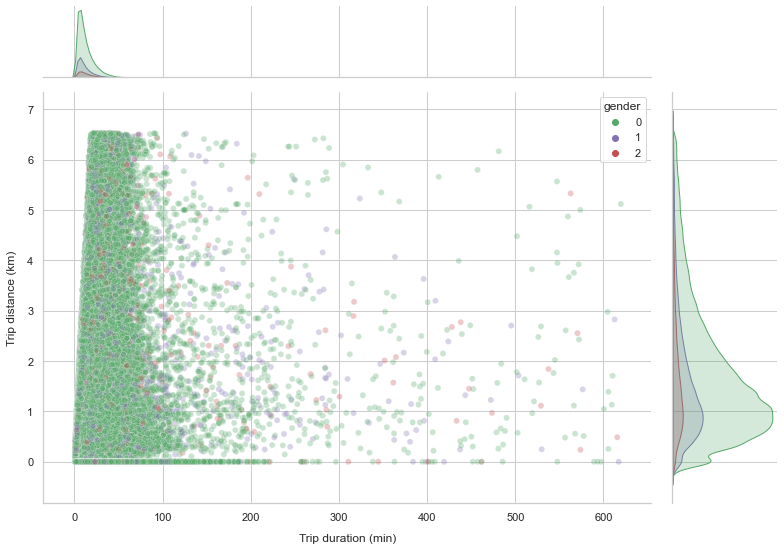

In [81]:
dur_dist_gen_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="gender", 
                                   palette={0: "g", 1: "m", 2: "r"}, 
                                   alpha=0.3)
dur_dist_gen_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_gen_plot.fig.set_size_inches(12, 8)

Just as we observed in genders before, most of the users have not registered their genders (genders of value 0). It can also be seen here that these users are the ones that have traveled a longer distance and a longer trip duration compared to those of gender values 1 and 2. In the next cell, we will remove these users.

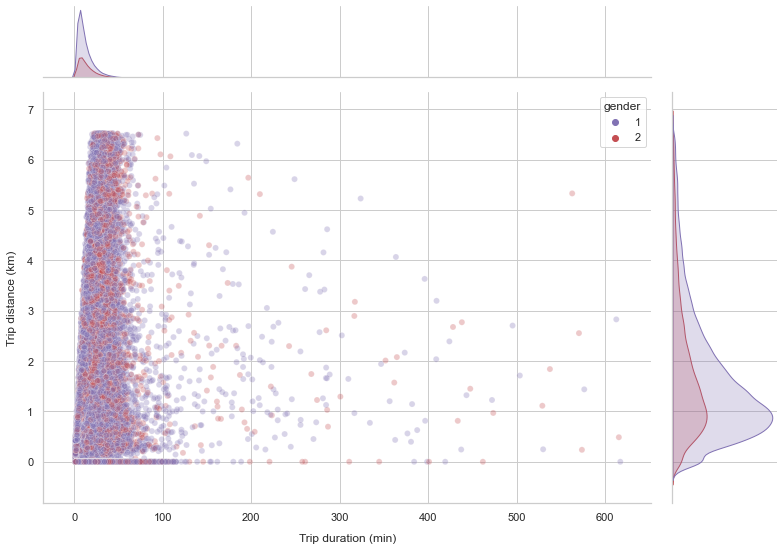

In [82]:
filtered_gender = np.array(data['gender']>0)
dur_dist_gen_plot = sns.jointplot(data=data[filtered_entries & filtered_dist & filtered_gender], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="gender", 
                                   palette={0: "g", 1: "m", 2: "r"}, 
                                   alpha=0.3)
dur_dist_gen_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_gen_plot.fig.set_size_inches(12, 8)

It can be seen that most of the users who have travelled longer distance and have had longer trip durations are of gender value `1`. It can also be observed that the users who have travelled a longer distance but had shorter trip durations are mostly of gender `1`. 

### Average trip distance per unique user, average duration per unique user and user type

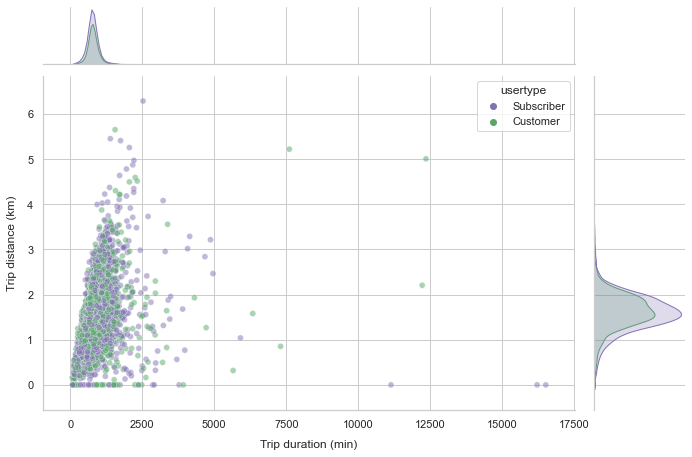

In [83]:
data_filtered = data[filtered_entries & filtered_dist]
avg_data2 = data_filtered[['bikeid','distance_km', 'tripduration','usertype']]
avg_data2 = avg_data2.groupby('bikeid').mean()
avg_data2['usertype'] = data_filtered['usertype']

#avg_data2.sort_values(by=['bikeid'])
#avg_data2

avg_data_plot2 = sns.jointplot(data=avg_data2, 
                                   x="tripduration", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
avg_data_plot2.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
avg_data_plot2.fig.set_size_inches(10.5, 6.5)

From the joint plot, it can be observed that most users who have travelled a longer average distance and have had longer average trip durations are Subscribers.

### Average trip distance per unique user, average duration per unique user, gender and user type

Two joint plots are created. One for the subscribers and one for the customers.

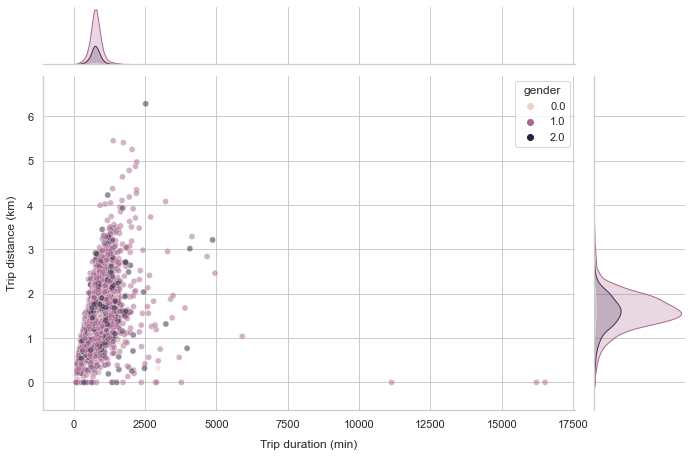

In [84]:
avg_data2['gender'] = data_filtered['gender']
avg_data2.sort_values(by=['bikeid'])

avg_subscriber = avg_data2[avg_data2['usertype']=='Subscriber']
avg_customer = avg_data2[avg_data2['usertype']=='Customer']
avg_customer.head()

#plot subscriber
avg_subscriber_plot2 = sns.jointplot(data=avg_subscriber, 
                                   x="tripduration", 
                                   y="distance_km", 
                                   hue="gender", 
                                   alpha=0.5)
avg_subscriber_plot2.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
avg_subscriber_plot2.fig.set_size_inches(10.5, 6.5)

The joint plot for the subscribers shows that gender 1 (male subscribers) have longer average trip durations and have had longer average trip distance compared to gender 0 and 2 (no gender indicated and female subscribers). It can also be observed that majority of the subscribers are male and there are very few who have not registered their genders.

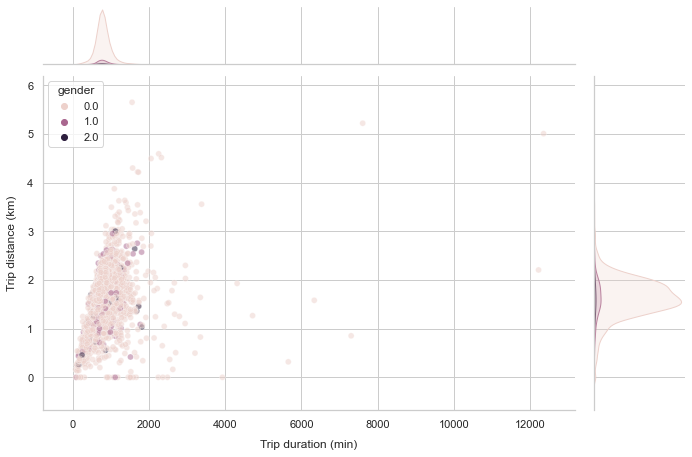

In [85]:
#plot customer
avg_customer_plot2 = sns.jointplot(data=avg_customer, 
                                   x="tripduration", 
                                   y="distance_km", 
                                   hue="gender", 
                                   alpha=0.5)
avg_customer_plot2.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
avg_customer_plot2.fig.set_size_inches(10.5, 6.5)

Based from the joint plot above, it is evident that most customers are of gender 0 (as observed earlier) and most customers that registered their gender are gender 1 users (males).